## London Rental Market Analysis: Pricing, Affordability & Trends”

# Content 
1. Distribution of Price, Bedrooms, Bathrooms, Income

2. Rent-to-Income Ratio: Calculation & Univariate Distribution

3. Affordability Buckets: Affordable / Borderline / Unaffordable

3. Rent vs. Bedrooms (Boxplot)

4. Median Rent by Borough (Bar Chart)

5. Time Trends of Average Rent (Line Plot)

6. Listings by Day of Week (Bar Chart)

In [35]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [36]:
listings= pd.read_csv("../data/list_new_clean.csv")
income = pd.read_csv("../data/income_by_borough.csv")
postcode_lookup= pd.read_csv("../data/postcodes_lookup_clean.csv")
time_dim = pd.read_csv("../data/time_dim_clean.csv")

postcode_lookup.rename(columns={'pcd': 'postcode'}, inplace=True)
print(postcode_lookup.columns.tolist())







['postcode', 'ward', 'borough']


In [37]:
## Pre cleaining ( standardize key columns) 
## already done in the data cleaning part but lets do this just incase
listings['postcode'] = listings['postcode'].str.strip().str.upper()
postcode_lookup['postcode'] = postcode_lookup['postcode'].str.strip().str.upper()


# Standardize borough names (optional: lowercase, strip)
income['borough'] = income['borough'].str.strip().str.title()
postcode_lookup['borough'] = postcode_lookup['borough'].str.strip().str.title()
listings['borough'] = listings['borough'].str.strip().str.title()

print(f"income boroughs {income['borough'].unique()}")

print("listings boroughs (from postcode_lookup)",listings['borough'].unique())

income boroughs ['Camden' 'Ealing' 'Hackney' 'Hammersmith And Fulham' 'Haringey'
 'Islington' 'Kensington And Chelsea' 'Lambeth' 'Lewisham' 'Newham'
 'Southwark' 'Tower Hamlets' 'Wandsworth' 'Westminster' 'City Of London']
listings boroughs (from postcode_lookup) ['Camden' 'City Of London' 'Ealing' 'Hackney' 'Hammersmith And Fulham'
 'Haringey' 'Islington' 'Kensington And Chelsea' 'Lambeth' 'Lewisham'
 'Newham' 'Southwark' 'Tower Hamlets' 'Wandsworth' 'Westminster']


Merge lookups

In [38]:
## Merge listings with postcode_lookup to get borough 

listings = listings.merge(postcode_lookup[['postcode','ward']], on='postcode',how='left')


## merge with income data borough borough
listings = listings.merge(income,on='borough',how='left')

## merge with time_dim 
listings['date_listed']= pd.to_datetime(listings['date_listed'],errors='coerce')
time_dim['date']= pd.to_datetime(time_dim['date'])
listing= listings.merge(time_dim, left_on='date_listed', right_on='date', how='left' )

In [39]:
#listings = listings.loc[:, ~listings.columns.str.endswith('_x')]

print(listings.columns.tolist())

listings['median_income']

['id', 'date_listed', 'bedrooms', 'bathrooms', 'summary', 'address', 'property_type', 'price_amount', 'price_frequency', 'latitude', 'longitude', 'description', 'property_url', 'borough', 'postcode', 'page', 'ward', 'year', 'median_income']


0       766.6
1       766.6
2       766.6
3       766.6
4       766.6
        ...  
3300    843.3
3301    843.3
3302    762.5
3303    727.8
3304    762.5
Name: median_income, Length: 3305, dtype: float64

In [40]:
# Create income mapping dictionary
income_data = {
    'Camden': 766.6,
    'Ealing': 684.8,
    'Hackney': 762.5,
    'Hammersmith And Fulham': 798.5,
    'Haringey': 727.8,
    'Islington': 811.2,
    'Kensington And Chelsea': 810.1,
    'Lambeth': 797.4,
    'Lewisham': 706.4,
    'Newham': 635.9,
    'Southwark': 788.6,
    'Tower Hamlets': 766.5,
    'Wandsworth': 843.3,
    'Westminster': 843.3,
    'City Of London': 853.4
}

In [41]:
# Convert weekly prices to monthly and standardize
listings.loc[listings['price_frequency'] == 'weekly', 'price_amount'] *= 4.33
listings['price_frequency'] = 'Monthly'  # standardize (fixed typo in 'Monthly')

# Convert weekly incomes to monthly
income_data_monthly = {k.lower(): v * 4.33 for k, v in income_data.items()}

# Create copies or use .loc to avoid chained assignment
reasonable_listings = listings.copy()  # This ensures you're working with a copy



print(reasonable_listings.columns)  # Verify 'rent_to_income' is in the output

Index(['id', 'date_listed', 'bedrooms', 'bathrooms', 'summary', 'address',
       'property_type', 'price_amount', 'price_frequency', 'latitude',
       'longitude', 'description', 'property_url', 'borough', 'postcode',
       'page', 'ward', 'year', 'median_income'],
      dtype='object')


Turn the rent frequency to monthly 

In [42]:
##Remove clear outliers 
# Convert weekly income to monthly (4.33 weeks/month)


## define borugh specific price caps (from rightmove 2024 benchmakrs)

borough_caps={
'Westminster':6000, # allow luxury properties
'Camden':3500,
'Kensington And Chelsea':8000,
'Tower Hamlets':3000,
'Islington': 3500,
'Newham': 2800,
'default':3000
}


reasonable_listings['borough_lower'] = reasonable_listings['borough'].str.lower()

reasonable_listings['price_cap']= reasonable_listings['borough'].map(borough_caps).fillna(borough_caps['default'])

reasonable_listings= reasonable_listings[reasonable_listings['price_amount']<=reasonable_listings['price_cap']].copy()

## remove HMo&per-rome listings 
#reasonable_listings= reasonable_listings[~reasonable_listings['description'].str.contains('room|HMO|Shared',case=False,na=False)]

# THEN calculate metrics
reasonable_listings['median_income_monthly'] = reasonable_listings['borough_lower'].map(income_data_monthly)
reasonable_listings['rent_to_income'] = reasonable_listings['price_amount'] / reasonable_listings['median_income_monthly']

print("Boroughs in reasonable_listings:", sorted(reasonable_listings['borough_lower'].unique()))
print("Boroughs in income_data_monthly:", sorted(income_data_monthly.keys()))

Boroughs in reasonable_listings: ['camden', 'city of london', 'ealing', 'hackney', 'hammersmith and fulham', 'haringey', 'islington', 'kensington and chelsea', 'lambeth', 'lewisham', 'newham', 'southwark', 'tower hamlets', 'wandsworth', 'westminster']
Boroughs in income_data_monthly: ['camden', 'city of london', 'ealing', 'hackney', 'hammersmith and fulham', 'haringey', 'islington', 'kensington and chelsea', 'lambeth', 'lewisham', 'newham', 'southwark', 'tower hamlets', 'wandsworth', 'westminster']


Set a price cap  based on rightmove benchmarks 

price_frequency
Monthly    2452
Name: count, dtype: int64


C:\Users\yeahm\AppData\Local\Temp\ipykernel_427176\1336759074.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


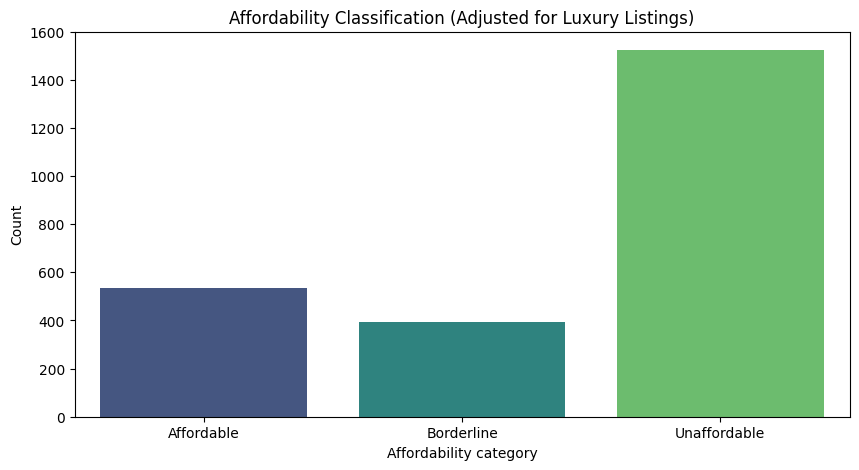


Affordability Distribution (%):
affordability
Unaffordable    62.2
Affordable      21.8
Borderline      16.1
Name: proportion, dtype: float64

Data Quality Checks:
Missing values in median_income: 0
Zero values in median_income: 0


In [46]:
# Adjust income for luxury listings
luxury_keywords = ['penthouse', 'luxury', 'mayfair', 'belgravia', 'exclusive', 'chelsea', 'kensington']
reasonable_listings['is_luxury'] = reasonable_listings['description'].str.contains('|'.join(luxury_keywords), case=False, na=False)

# Verify price frequency conversion
print(reasonable_listings['price_frequency'].value_counts())


#reasonable_listings.loc[reasonable_listings['is_luxury'], 'adjusted_income'] *= 2  # Double income for luxury properties

reasonable_listings['rent_to_income'] = reasonable_listings['price_amount'] / reasonable_listings['median_income_monthly']

# Define more realistic affordability bins
reasonable_listings['affordability'] = pd.cut(
    reasonable_listings['rent_to_income'],
    bins=[0, 0.3, 0.5, float('inf')],  # More standard affordability thresholds
    labels=['Affordable', 'Borderline', 'Unaffordable']
)

# Plot counts 
plt.figure(figsize=(10, 5))
sns.countplot(
    data=reasonable_listings,
    x='affordability',
    order=['Affordable', 'Borderline', 'Unaffordable'],
    palette='viridis'
)
plt.title("Affordability Classification (Adjusted for Luxury Listings)")
plt.xlabel("Affordability category")
plt.ylabel("Count")
plt.show()

# Summary stats (percentages)
print("\nAffordability Distribution (%):")
print(reasonable_listings['affordability'].value_counts(normalize=True).round(3) * 100)

# Data quality checks
print("\nData Quality Checks:")
print("Missing values in median_income:", reasonable_listings['median_income_monthly'].isnull().sum())
print("Zero values in median_income:", (reasonable_listings['median_income_monthly'] == 0).sum())
#print("Sample income values:\n", reasonable_listings[['borough', 'median_income_monthly', 'is_luxury', 'adjusted_income']].head(5))

Affordability Distribution: Majority of the listings in the last 6 months have been unaffordable based on the median income per borough in inner london 

In [47]:


reasonable_listings['median_income'] = reasonable_listings['borough'].map(income_data)

reasonable_listings['median_income'].describe()

count    2452.000000
mean      775.478181
std        54.912429
min       635.900000
25%       762.500000
50%       766.600000
75%       810.100000
max       853.400000
Name: median_income, dtype: float64

In [48]:
# Convert weekly rents to monthly
reasonable_listings.loc[
    reasonable_listings['price_frequency'].str.lower().str.contains('week'), 
    'price_amount'
] *= 4.33

# Calculate monthly income and ratio
reasonable_listings['monthly_income'] = reasonable_listings['median_income'] * 4.33
reasonable_listings['rent_to_income'] = (
    reasonable_listings['price_amount'] / 
    reasonable_listings['monthly_income']
)

# Luxury adjustment (1.5x income multiplier)
luxury_terms = ['penthouse','luxury','mayfair','belgravia','exclusive']
reasonable_listings['is_luxury'] = reasonable_listings['description'].str.contains(
    '|'.join(luxury_terms), 
    case=False, 
    na=False
)
#reasonable_listings.loc[reasonable_listings['is_luxury'], 'rent_to_income'] /= 1.5


reasonable_listings[ 'rent_to_income']

0       0.331387
1       0.776652
2       0.707964
3       0.542270
4       0.497081
          ...   
3297    0.182450
3298    0.617666
3301    0.985899
3302    0.454322
3303    0.210384
Name: rent_to_income, Length: 2452, dtype: float64

In [52]:
def assign_affordability(row):
    try:
        if pd.isna(row['rent_to_income']):
            return None

        if row['borough'] in ['Westminster', 'Kensington And Chelsea']:
            if row['rent_to_income'] <= 0.25:
                return 'Affordable'
            elif row['rent_to_income'] <= 0.4:
                return 'Borderline'
            else:
                return 'Unaffordable'
        else:
            if row['rent_to_income'] <= 0.3:
                return 'Affordable'
            elif row['rent_to_income'] <= 0.5:
                return 'Borderline'
            else:
                return 'Unaffordable'
    except Exception as e:
        print(f"Error processing row: {e}")
        return None

reasonable_listings['affordability'] = reasonable_listings.apply(assign_affordability, axis=1)



Assign affordability based on treshhold of income to rent ratio

In [53]:

print(reasonable_listings['affordability'].value_counts(normalize=True))




affordability
Unaffordable    0.630914
Affordable      0.213295
Borderline      0.155791
Name: proportion, dtype: float64


* After normalizing rent frequency to monthly amounts and filtering out luxury outliers and price cap extremes, I evaluated rental affordability using borough-level median incomes.

* The results show that over 63% of properties are unaffordable — defined as a rent-to-income ratio exceeding 30%, or 40% in high-income boroughs like Westminster and Kensington & Chelsea.

* This confirms the structural unaffordability of London’s private rental market for the average resident.


# 1. Borough Level affordability plot

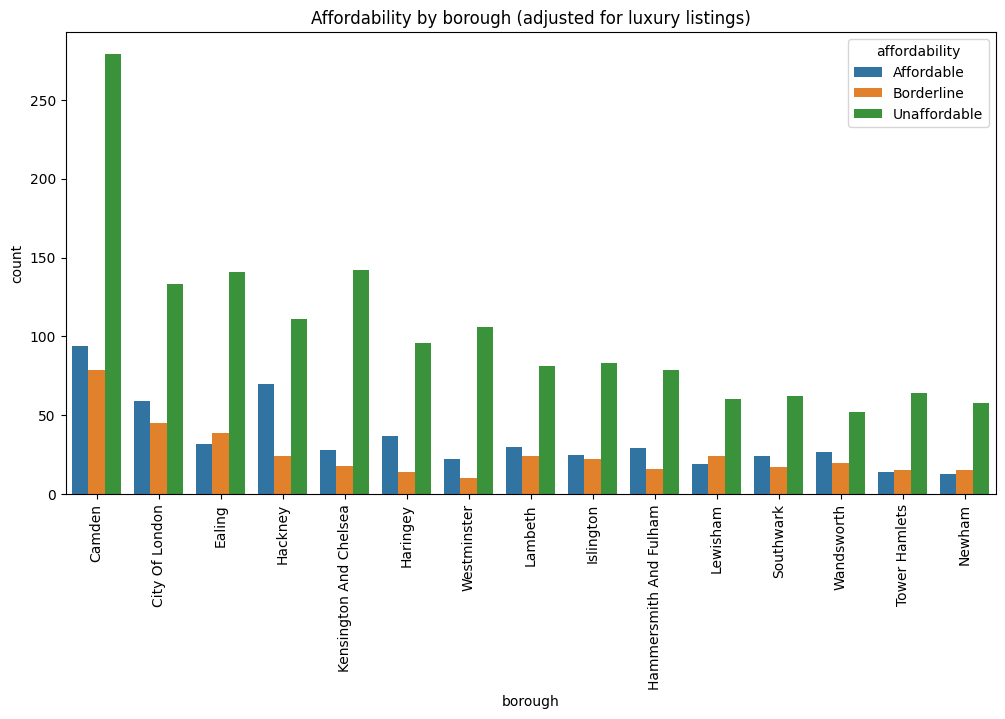

In [54]:
plt.figure(figsize=(12,6))
sns.countplot(
    data= reasonable_listings,
    x='borough',
    hue='affordability',
    order=reasonable_listings['borough'].value_counts().index, 
    hue_order=['Affordable','Borderline','Unaffordable']
)

plt.xticks(rotation=90)
plt.title("Affordability by borough (adjusted for luxury listings)")
plt.show()

# 1.1 Worst boroughs for affordability

In [55]:


unaffordable_pct = reasonable_listings.groupby('borough')['affordability'].apply(lambda x: (x == 'Unaffordable').mean()).sort_values(ascending=False).head(5)

print("Most Unaffordable Boroughs:")
print(unaffordable_pct.round(3))

Most Unaffordable Boroughs:
borough
Westminster               0.768
Kensington And Chelsea    0.755
Tower Hamlets             0.688
Newham                    0.674
Ealing                    0.665
Name: affordability, dtype: float64


# 2. Rent to income Ratio

<function matplotlib.pyplot.show(close=None, block=None)>

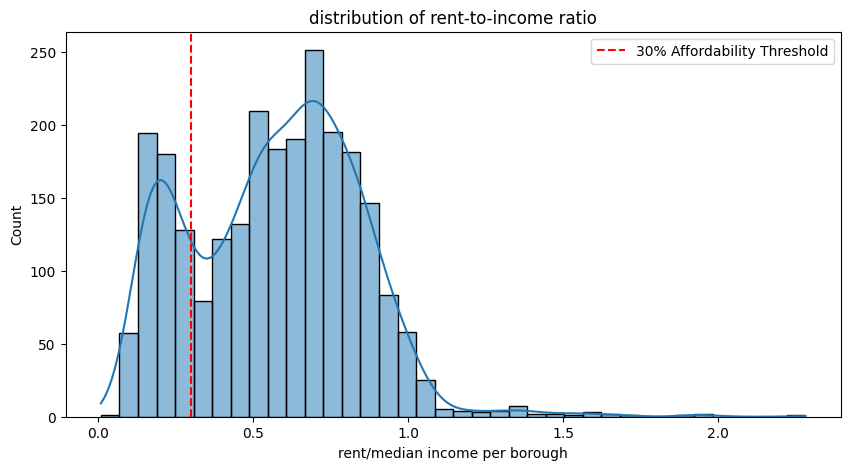

In [56]:

plt.figure(figsize=(10,5))
sns.histplot(reasonable_listings['rent_to_income'].dropna(),kde=True)
plt.title("distribution of rent-to-income ratio")
plt.xlabel("rent/median income per borough")
plt.axvline(x=0.3, color='red', linestyle='--', label='30% Affordability Threshold')
plt.legend()
plt.show

1. Key Findings on Rent-to-Income Ratios in London:
Unaffordable Majority:

Most rentals (>0.3 ratio): The bulk of listings exceed the 30% affordability threshold, with a dominant cluster around 0.5–0.6—meaning rent consumes 50–60% of borough-wide median income.

Theoretical vs. Reality: Even if "affordable" by lax standards (e.g., ratios <1.0), these rentals still force median earners into financial strain (e.g., reduced savings, discretionary spending).

Outliers (>1.0 ratio):

Likely luxury units or listings in high-income areas (e.g., Kensington) where median income doesn’t reflect tenant demographics.

2. Skewness Implications
The right-skewed distribution reveals two critical insights:

Disproportionate Expense: Most listings are concentrated at ratios higher than the median, indicating systemic unaffordability.

Hidden Burden: The skew might understate the crisis because:

Tenant incomes ≤ borough median: Many renters (e.g., service workers, young professionals) earn below their borough’s median income, making their actual rent-to-income ratios even worse.


# 1. Distribution of Price, Bedrooms, Bathrooms, Income

C:\Users\yeahm\AppData\Local\Temp\ipykernel_427176\2173515097.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bedrooms', data=reasonable_listings, ax=axes[0,1], palette='viridis')
C:\Users\yeahm\AppData\Local\Temp\ipykernel_427176\2173515097.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bathrooms', data=reasonable_listings, ax=axes[1,0], palette='magma')


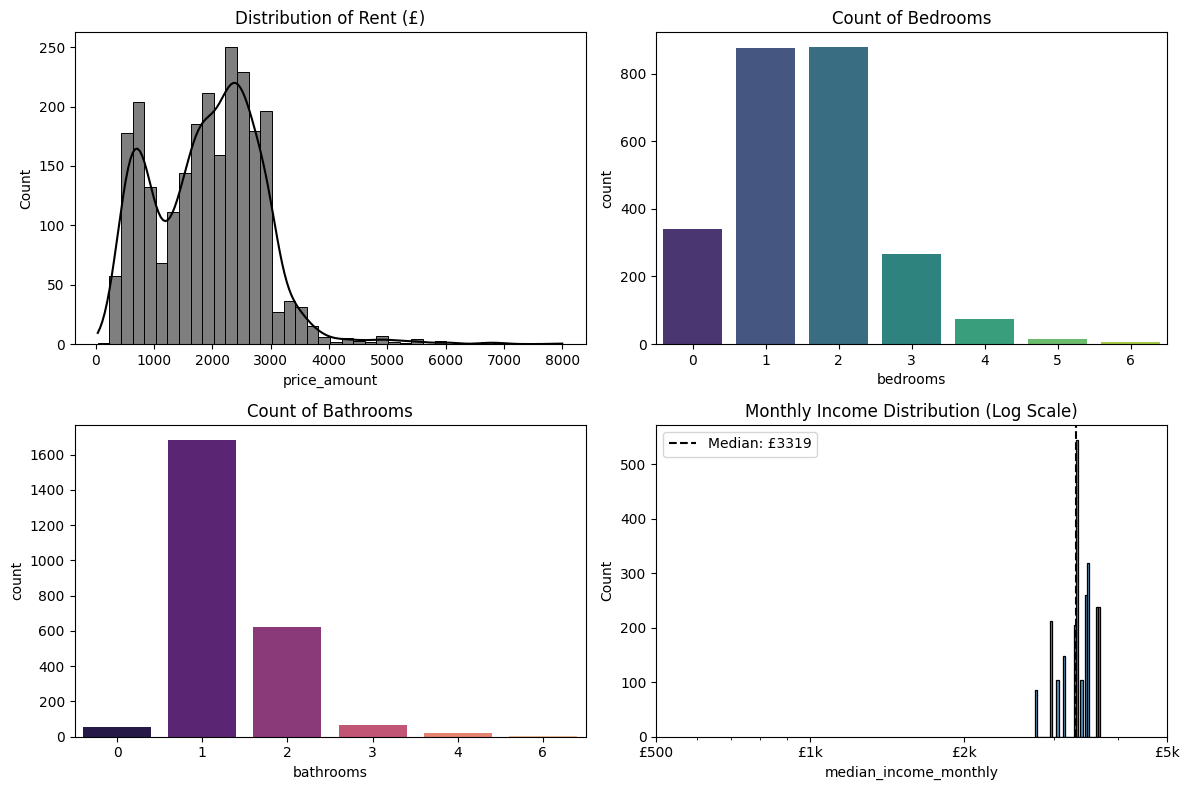

In [58]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# --- Top Row: Rent and Bedrooms ---
sns.histplot(reasonable_listings['price_amount'], kde=True, ax=axes[0,0], color='black')
axes[0,0].set_title("Distribution of Rent (£)")

sns.countplot(x='bedrooms', data=reasonable_listings, ax=axes[0,1], palette='viridis')
axes[0,1].set_title("Count of Bedrooms")

# --- Bottom Row: Bathrooms and Income ---
sns.countplot(x='bathrooms', data=reasonable_listings, ax=axes[1,0], palette='magma')
axes[1,0].set_title("Count of Bathrooms")

# Median Income (Log Scale - FIXED)
# Convert to monthly (assuming 4.33 weeks/month)
reasonable_listings['median_income_monthly'] = reasonable_listings['median_income'] * 4.33
sns.histplot(reasonable_listings['median_income_monthly'], bins=30, log_scale=True, ax=axes[1,1])
axes[1,1].set_title("Monthly Income Distribution (Log Scale)")

# Set clean log-scale x-axis ticks
axes[1,1].set_xticks([500, 1000, 2000, 5000])  # Custom ticks in £
axes[1,1].set_xticklabels(["£500", "£1k", "£2k", "£5k"])  # Readable labels

# Add median/mean lines for context
median = reasonable_listings['median_income_monthly'].median()
axes[1,1].axvline(median, color='black', linestyle='--', label=f'Median: £{median:.0f}')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# 4. Rent vs Bedrooms (boxplot)

C:\Users\yeahm\AppData\Local\Temp\ipykernel_427176\3827709588.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='bedrooms', y='price_amount', data=reasonable_listings, palette='Blues', flierprops={'marker':'o','markersize':8, 'markerfacecolor':'red'})


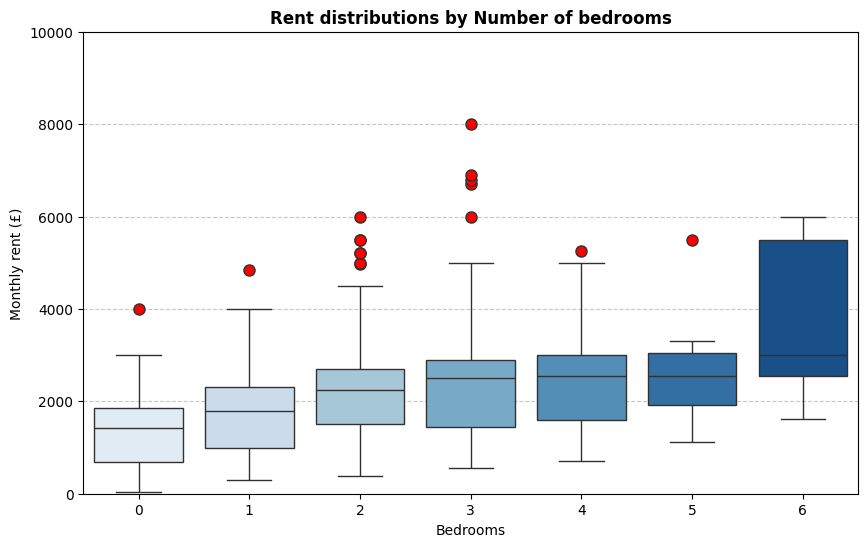

In [59]:

plt.figure(figsize=(10,6))
sns.boxplot(x='bedrooms', y='price_amount', data=reasonable_listings, palette='Blues', flierprops={'marker':'o','markersize':8, 'markerfacecolor':'red'})
plt.title("Rent distributions by Number of bedrooms", fontweight='bold')
plt.xlabel("Bedrooms")
plt.ylabel("Monthly rent (£)")
plt.ylim(0,10000)
plt.grid(axis='y', linestyle='--', alpha =0.7)
plt.show()

# See if outliers are marked as luxury


the datasets align with London's rental market trends. Outliers are concentrated in high-income boroughs (e.g., Westminster, Kensington and Chelsea), where premium rents are expected. this suggests the data is credible, with outliers reflecting real-world market extremes.

* price_amount  bedrooms                 borough postcode
* 3079        6800.0         3  Kensington And Chelsea  SW3 1DB
* 2682        6000.0         3             Westminster  SW1P3ZR
* 1067        5500.0         2  Kensington And Chelsea  SW5 0AJ
* 2997        5200.0         2  Kensington And Chelsea   W2 4TL
* 2006        4849.0         1  Kensington And Chelsea  SW109BA
* 2093        4849.0         3             Westminster  W1N 7FE
* 2637        4658.0         4  Kensington And Chelsea  SW100JA
* 2721        4600.0         4  Kensington And Chelsea  SW3 4ZR
* 1825        4500.0         2  Kensington And Chelsea   W8 7AB
* 1497        4312.0         2             Westminster   W2 4AU

<Axes: title={'center': 'Outliers by Property Type'}, xlabel='property_type'>

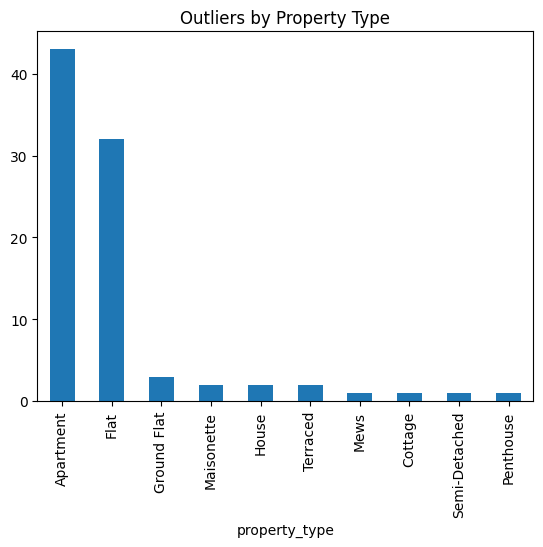

In [541]:
# Get top 5% most expensive 2-3 bed listings
outliers = reasonable_listings[
    (reasonable_listings['bedrooms'].isin([2, 3])) &
    (reasonable_listings['price_amount'] > reasonable_listings['price_amount'].quantile(0.95))
]

# Breakdown by property type
outliers['property_type'].value_counts().plot(kind='bar', title="Outliers by Property Type")

In [542]:
# Inspect top 10 most expensive flats
flats_outliers = reasonable_listings[
    (reasonable_listings['property_type'] == 'Flat') & 
    (reasonable_listings['price_amount'] > reasonable_listings['price_amount'].quantile(0.95))
].sort_values('price_amount', ascending=False).head(10)

print(flats_outliers[['price_amount', 'bedrooms', 'borough', 'postcode']])

      price_amount  bedrooms                 borough postcode
3079        6800.0         3  Kensington And Chelsea  SW3 1DB
2682        6000.0         3             Westminster  SW1P3ZR
1067        5500.0         2  Kensington And Chelsea  SW5 0AJ
2997        5200.0         2  Kensington And Chelsea   W2 4TL
2006        4849.0         1  Kensington And Chelsea  SW109BA
2093        4849.0         3             Westminster  W1N 7FE
2637        4658.0         4  Kensington And Chelsea  SW100JA
2721        4600.0         4  Kensington And Chelsea  SW3 4ZR
1825        4500.0         2  Kensington And Chelsea   W8 7AB
1497        4312.0         2             Westminster   W2 4AU


# 5. Median Rent by Borough 
 

C:\Users\yeahm\AppData\Local\Temp\ipykernel_282888\852828816.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=borough_rent.index, y=borough_rent.values, palette='viridis')


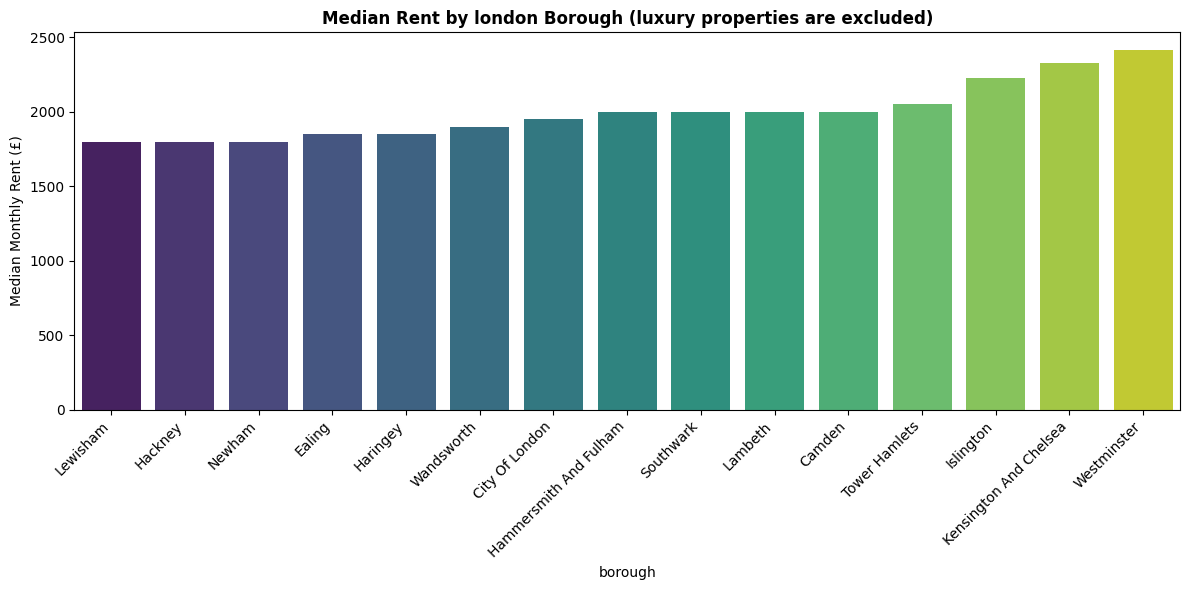

In [548]:


borough_rent= reasonable_listings.groupby('borough')['price_amount'].median().sort_values(ascending=True)
#plot 
plt.figure(figsize=(12,6))
sns.barplot(x=borough_rent.index, y=borough_rent.values, palette='viridis')
plt.title("Median Rent by london Borough (luxury properties are excluded)", fontweight='bold')
plt.xlabel('borough')
plt.ylabel("Median Monthly Rent (£)")
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

# 6. Time Trends of average rent over time

In [568]:
reasonable_listings['date_listed']= pd.to_datetime(reasonable_listings['date_listed'],errors='coerce')


## extract year-month

reasonable_listings['year_month']= reasonable_listings['date_listed'].dt.to_period('M')

## Calculate average rent by month
monthly_avg_rent = reasonable_listings.groupby('year_month')['price_amount'].mean().reset_index()

## 6 months period too small and will lead to sharp jumps, so use mean of 3 month averages to get a reasonable measurement
monthly_avg_rent['smoothed_rent'] = reasonable_listings['price_amount'].rolling(window=3).mean()
## convert to datetime for plottings
monthly_avg_rent['year_month']= monthly_avg_rent['year_month'].dt.to_timestamp()



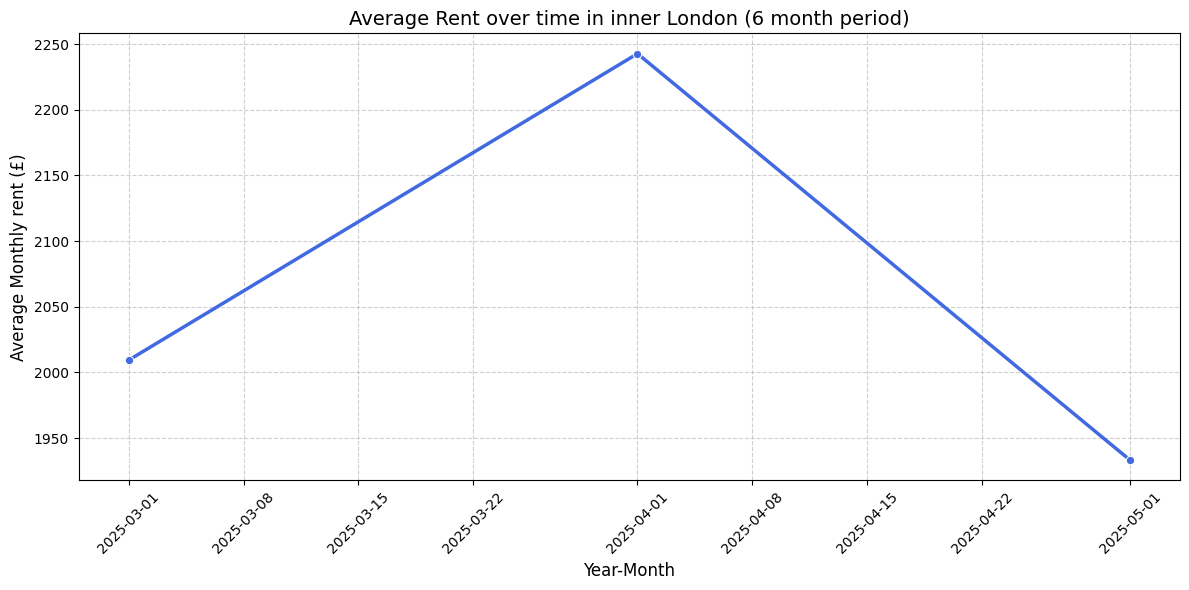

In [569]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_avg_rent,
    x='year_month',
    y='smoothed_rent',
    marker='o',
    color='royalblue',
    linewidth=2.5
)


plt.title("Average Rent over time in inner London (6 month period)", fontsize=14)
plt.xlabel('Year-Month',fontsize=12)
plt.ylabel("Average Monthly rent (£)", fontsize=12)
plt.grid(True,linestyle='--', alpha=0.6)


plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 7. Listings by Day

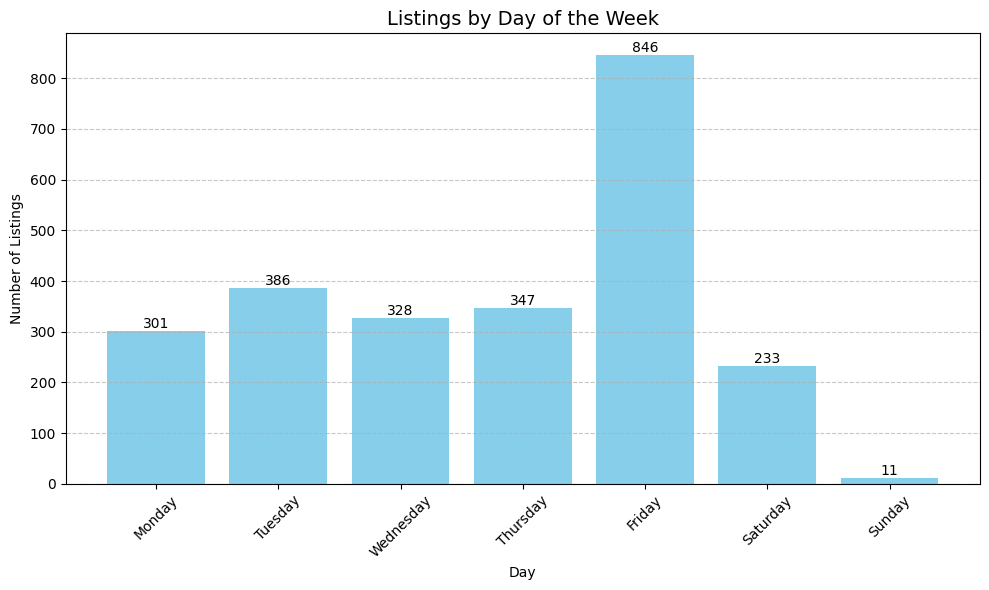

In [575]:
# Convert 'date_listed' to datetime (if not already done)
reasonable_listings['date_listed'] = pd.to_datetime(reasonable_listings['date_listed'], errors='coerce')

# Extract day of week 
reasonable_listings['day_of_week'] = reasonable_listings['date_listed'].dt.dayofweek  
reasonable_listings['day_name'] = reasonable_listings['date_listed'].dt.day_name()   

# Count listings by day of week
day_counts = reasonable_listings['day_name'].value_counts().sort_index()

# Define correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order)


plt.figure(figsize=(10, 6))
bars = plt.bar(day_counts.index, day_counts.values, color='skyblue')

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.title('Listings by Day of the Week', fontsize=14)
plt.xlabel('Day')
plt.ylabel('Number of Listings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [576]:
reasonable_listings.to_csv('reasonable_listings.csv',index=False)